In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import circularFiltering as flt
from scipy.stats import vonmises
import matplotlib
import glob
import re
import os
matplotlib.rcParams.update({'font.size': 14,
                            'pdf.fonttype': 42,
                            'ps.fonttype': 42})
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})




### Parameters

In [3]:
T = 10 # simulation time
dt = 0.01 # step size
t = np.arange(0,T,dt)
kappa_phi = 1 # inverse diffusion constant
phi_0 = 0 # initial mean
kappa_0 = 20 # initial certainty

# colors for plotting
col_PF = 'xkcd:green'
col_ADF = 'xkcd:blue'
col_vM = 'xkcd:orange'

##
Simulations were run on the HPC cluster with the same parameters as above for nIter=5000 times. Here, we analyse, but for a significantly longer runtime. Here, we load this data and compare.

In [4]:
def backToCirc(phi):
    phi = ( (phi+np.pi) % (2*np.pi) ) - np.pi
    return phi

## Preprocessing

In [6]:
kappa_z_array = ([1.e-02, 3.e-02, 1.e-01, 2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01,
       7.e-01, 8.e-01, 9.e-01, 1.e+00, 2.e+00, 3.e+00, 4.e+00, 5.e+00,
       6.e+00, 7.e+00, 8.e+00, 9.e+00, 1.e+01, 3.e+01, 1.e+02])

preprocess = False # only set to True if you want to re-run preprocessing on data in /data_raw

path_processed = 'data_processed/'
path_raw = 'data_raw/figure2i/'

if preprocess:

    # # make unique list of parameter values
    fileNames = glob.glob(os.path.join(path_raw, "k=*.npz"))
    kappa_array = np.array( [ re.findall('(?<=k=)(.*)(?=_)', name) for name in fileNames ] )[:,0]
    kappa_array = np.unique(kappa_array.astype(float))
    kappa_z_array = np.array( [ re.findall('(?<=kz=)(.*)(?=\.)', name) for name in fileNames ] )[:,0]
    kappa_z_array = np.unique(kappa_z_array.astype(float))


    len_kz = len(kappa_z_array)
    len_k = len(kappa_array)

    phi = np.zeros([len_k,len_kz])
    vonMises_stats = np.zeros([len_k,len_kz,3]) # 1st (bias + variance) and 2nd order statistics for each kappa_z,
    vonMises_q_stats = np.zeros([len_k,len_kz,3])
    PF_stats = np.zeros([len_k,len_kz,3])
    noUncert_stats = np.zeros([len_k,len_kz,2])

    for i in np.arange(len_k):
        if i == 0:
            for j in np.arange(len_kz):
                kappa = kappa_array[i]
                kappa_z = kappa_z_array[j]
                filename = path_raw+"k="+str(kappa)+"_kz="+str(kappa_z)
                data = np.load(filename+'.npz')

                # simulation data arrays, mean and kappa (r for PF) for each run
                vonMises=data['vonMises']
                vonMises_q=data['vonMises_q']
                noUncert = data['noUncert']
                PF=data['PF']
                phi_final = data['phi_final']

                # collect 2nd order statistics at end of simulation(precision as computed by filter)
                vonMises_stats[i,j,2] = np.mean(vonMises[:,1])
                vonMises_q_stats[i,j,2] = np.mean(vonMises_q[:,1])
                PF_stats[i,j,2] = np.mean(PF[:,1])


                # collect 1st order statistics (bias as phase of circular mean, precision as radius of circular mean)
                vonMises_stats[i,j,[0,1]] = flt.circular_mean(flt.backToCirc(vonMises[:,0]-phi_final))
                vonMises_q_stats[i,j,[0,1]] = flt.circular_mean(flt.backToCirc(vonMises_q[:,0]-phi_final))
                PF_stats[i,j,[0,1]] = flt.circular_mean(flt.backToCirc(PF[:,0]-phi_final))
                noUncert_stats[i,j] = flt.circular_mean(flt.backToCirc(noUncert - phi_final))

        else:
            for j in np.arange(len_kz):
                kappa = kappa_array[i]
                kappa_z = kappa_z_array[j]
                filename = path_raw+"k="+str(kappa)+"_kz="+str(kappa_z)
                data = np.load(filename+'.npz')

                noUncert = data['noUncert']
                phi_final = data['phi_final']

                # collect 1st order statistics (bias as phase of circular mean, precision as radius of circular mean)
                noUncert_stats[i,j] = flt.circular_mean(flt.backToCirc(noUncert - phi_final))
    
    # save the preprocessed data
    np.savez(path_processed+'figure2i',
        vonMises_stats=vonMises_stats,vonMises_q_stats=vonMises_q_stats,PF_stats=PF_stats,noUncert_stats=noUncert_stats)

else:
    data = np.load(path_processed+'figure2i.npz')
    vonMises_stats = data['vonMises_stats']
    vonMises_q_stats = data['vonMises_q_stats']
    PF_stats = data['PF_stats']
    noUncert_stats = data['noUncert_stats']


### Summary plots at T = 10
#### Error measures

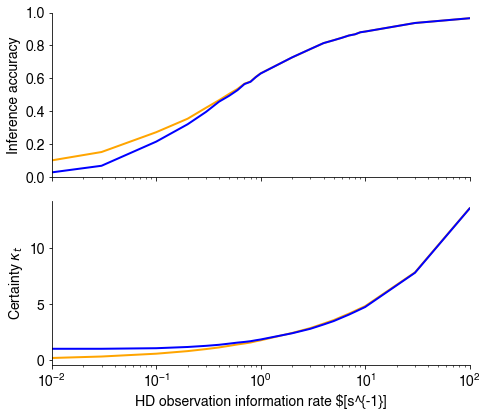

In [8]:

fig, (ax1,ax2) = plt.subplots(ncols=1,nrows=2,figsize = (7,6),sharex=True,tight_layout=True)

# first order statistics
ax1.plot(kappa_z_array,vonMises_stats[0,:,1],label='Projection Filter',linewidth=2,color='orange')
ax1.plot(kappa_z_array,vonMises_q_stats[0,:,1],label='Q Apppr',linewidth=2,color='blue')
# ax1.plot(kappa_z_array,PF_stats[:,1],'--',label='ParticleFilter',linewidth=3,color=col_PF)
ax1.set_ylabel(r'Inference accuracy')
ax1.set_xscale('log')
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_ylim([0,1])
ax1.set_xlim([kappa_z_array[0],kappa_z_array[-1]])
# ax1.legend()

# second order statistics
ax2.plot(kappa_z_array,vonMises_stats[0,:,2],label='Projection Filter',linewidth=2,color='orange')
ax2.plot(kappa_z_array,vonMises_q_stats[0,:,2],label='Projection Filter',linewidth=2,color='blue')
# ax2.plot(kappa_z_array,PF_stats[:,2],'--',label='ParticleFilter',linewidth=3,color=col_PF)
ax2.set_ylabel('Certainty $\kappa_t$')
ax2.set_xlabel(r'HD observation information rate $[s^{-1}]')
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_xscale('log')
# plt.savefig('Figure3/MSE.pdf',format='pdf',transparent=True)

plt.show()